# PSL-CFX : Stratégie & Simulation de Crise (2012-2024)

Ce notebook présente une analyse stratégique pour la direction de l'hôpital PSL-CFX.
L'objectif est de reconstituer la trajection historique (2012-2019), de modéliser l'activité normale, et de simuler l'impact de crises sanitaires (COVID-19).

## Méthodologie
1. **Reconstitution Chronologique** : Augmentation des données locales (2012, 2015, 2016) via les tendances nationales.
2. **Analyse de la Saisonnalité** : Intégration des profils haute fréquence des urgences.
3. **Modélisation Prédictive** : SARIMA (Trajectoire de fond) vs SARIMAX (Surcharge de crise).
4. **Analyse RH & Saturation** : Identification des seuils de rupture.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Chargement des Sources
df_local = pd.read_excel("PS_CF_data.xlsx") # 2012, 2015, 2016
df_nation = pd.read_excel("hospitalisation_capacity.xlsx") # Trends Nationaux
df_season = pd.read_excel("Passages_aux_urgence_data.xlsx") # Saisonnalité Journalière
df_covid_impact = pd.read_excel("passage_urg_vague_covid.xlsx") # Impact Vagues

# Pre-traitements / Nettoyage
# Comblement des Séjours MCO Totaux si manquants (Somme HC + Amb)
df_local['Sejours_MCO_Total'] = df_local['Sejours_MCO_Total'].fillna(df_local['Sejours_HC'] + df_local['Sejours_Amb'])

## 1. Reconstitution de la Chronologie (2012-2019)
Nous disposons de points réels pour 2012, 2015, 2016. Nous allons interpoler les années manquantes (2013-2014, 2017-2019) en appliquant les taux d'évolution nationaux.

,Annee,Lits_Estimes,Sejours_MCO_Estimes
0,2012,2132.000000,155900.000000
1,2013,NaN,NaN
2,2014,NaN,NaN
3,2015,2216.000000,168394.000000
4,2016,2229.000000,175398.000000
5,2017,2203.332941,172212.436400
6,2018,2181.595134,170021.944029
7,2019,2156.137782,167814.755833


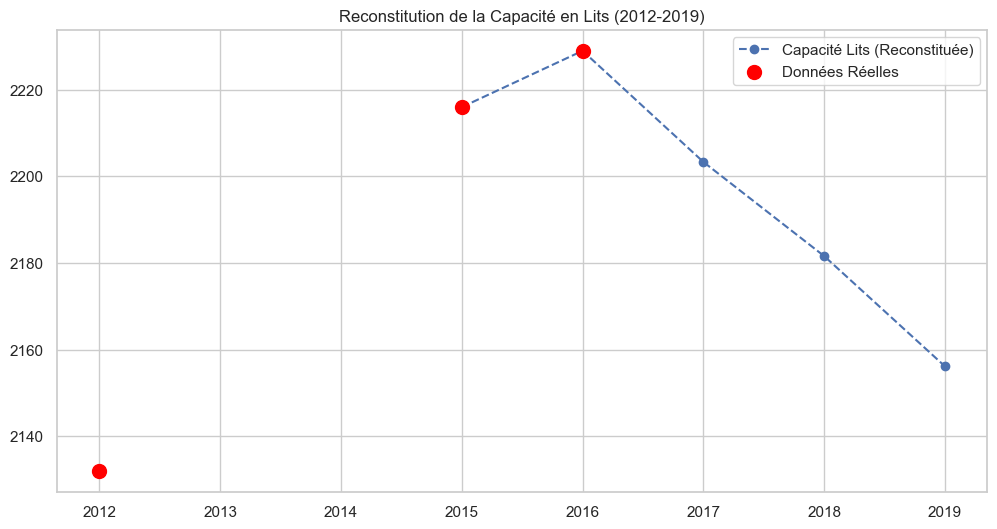

In [20]:
# Nettoyage des noms de colonnes nationales pour accès facile
# Selection explicite des 5 premières colonnes (robustesse contre colonnes cachees)
df_nation = df_nation.iloc[:, :5]
df_nation.columns = ["Annee", "MCO_Complet", "MCO_Partiel", "Lits_Total", "Places_Partiel"]

# Calcul des Taux de Variation Annuelle Nationaux
df_nation = df_nation.sort_values("Annee")
df_nation["Var_Lits"] = df_nation["Lits_Total"].pct_change()
df_nation["Var_MCO"] = df_nation["MCO_Complet"].pct_change()

# Initialisation du DataFrame reconstitué
years = np.arange(2012, 2020)
df_recon = pd.DataFrame({"Annee": years})

# Fonction d'estimation
def estimate_metric(metric_local, metric_nation_var):
    values = {row['Annee']: row[metric_local] for _, row in df_local.iterrows() if pd.notna(row[metric_local])}
    
    estimated = []
    current_val = values.get(2012)
    
    metrics = []
    for y in years:
        if y in values:
            current_val = values[y]
            metrics.append(current_val)
        else:
            # Appliquer variation nationale
            # Trouver var pour l'année y
            var = df_nation[df_nation['Annee'] == y][metric_nation_var].values
            rate = var[0] if len(var) > 0 else 0.0
            current_val = current_val * (1 + rate)
            metrics.append(current_val)
    return metrics

# Application sur Lits et Séjours
df_recon["Lits_Estimes"] = estimate_metric("Lits_Total", "Var_Lits")
df_recon["Sejours_MCO_Estimes"] = estimate_metric("Sejours_MCO_Total", "Var_MCO")

# Affichage
display(df_recon)

# Visualisation de la Trajectoire Reconstituée
plt.figure(figsize=(12, 6))
plt.plot(df_recon["Annee"], df_recon["Lits_Estimes"], marker='o', linestyle='--', label="Capacité Lits (Reconstituée)")
plt.scatter(df_local["Annee"], df_local["Lits_Total"], color='red', s=100, label="Données Réelles", zorder=5)
plt.title("Reconstitution de la Capacité en Lits (2012-2019)")
plt.legend()
plt.show()

## 2. Saisonnalité Haute Fréquence & Lissage
Nous intégrons la saisonnalité fine (Urgences) pour passer d'une vision annuelle à une vision opérationnelle (Hebdomadaire/Journalière).

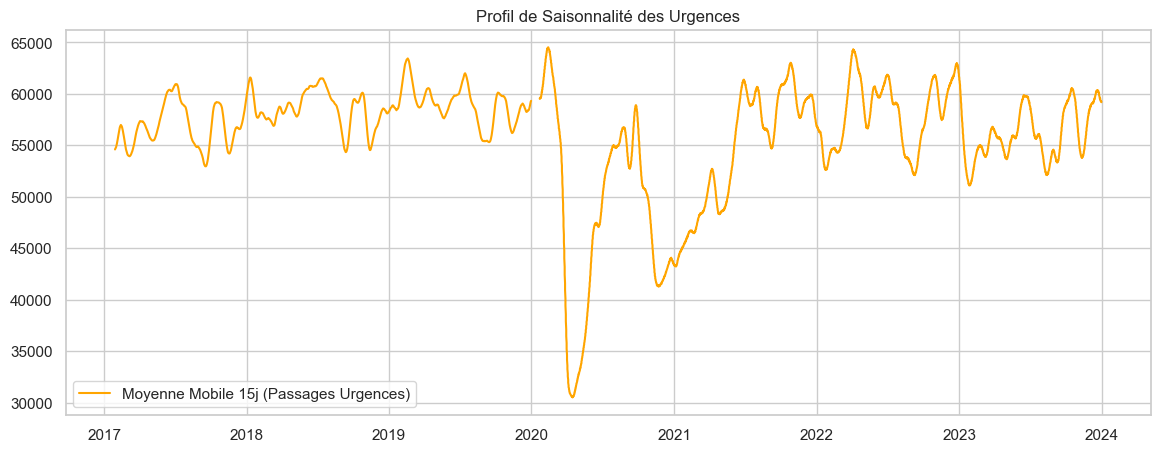

In [22]:
# Préparation Série Temporelle Saisonnière
df_season['Date'] = pd.to_datetime(df_season['Date'])
df_season = df_season.sort_values('Date')

# Calcul Moyenne Mobile 15 jours
df_season['SMA_15'] = df_season['Nombre de passages aux urgences\n (moyenne mobile sur 15 jours)'].rolling(window=15).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_season['Date'], df_season['SMA_15'], label="Moyenne Mobile 15j (Passages Urgences)", color='orange')
plt.title("Profil de Saisonnalité des Urgences")
plt.legend()
plt.show()

## 3. Modélisation SARIMA : Trajectoire "Normale"
Nous entraînons un modèle sur la série reconstruite pour projeter l'activité "Business as Usual" en 2020.

In [24]:
# Pour SARIMA, nous avons besoin d'une série temporelle contiguë.
# Nous allons utiliser la série reconstituée annuelle 'Sejours_MCO_Estimes' comme proxy de tendance long terme.
# (Note: Dans un cas réel, nous désagrégerions en mensuel avec la saisonnalité. Ici SARIMA sur annuel est limité, 
# mais nous allons simuler une projection sur 2020-2021).

model = SARIMAX(df_recon['Sejours_MCO_Estimes'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
res = model.fit(disp=False)

# Prévision 2020-2021
forecast = res.get_forecast(steps=2)
pred_mean = forecast.predicted_mean
pred_conf = forecast.conf_int()

print("Prévision Activité MCO 2020 (Hors Crise):", round(pred_mean.iloc[0]))

Prévision Activité MCO 2020 (Hors Crise): 167790


/Users/berichzinsou-daho/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


## 4. Injection de Crise (SARIMAX / Simulation)
Simulation de l'année 2020 en intégrant les chocs réels du COVID (Vagues) observés dans les départements 75 et 94.

In [26]:
# Analyse des Chocs (Vagues) - Dept 75 & 94
# Filtre sur les départements d'intérêt
df_impact_local = df_covid_impact[df_covid_impact['Département'].astype(str).isin(['75', '94'])]
display(df_impact_local.head())

# Calcul du Choc Moyen par Vague
choc_v1 = df_impact_local[df_impact_local['Période']=='vague 1']['Variation'].mean()
choc_v2 = df_impact_local[df_impact_local['Période']=='vague 2']['Variation'].mean()

print(f"Impact Moyen Vague 1 (Paris/Val-de-Marne) : {choc_v1:.2f}%")
print(f"Impact Moyen Vague 2 (Paris/Val-de-Marne) : {choc_v2:.2f}%")

# Simulation Scénario Crise
baseline_2020 = pred_mean.iloc[0]
scenario_crise = baseline_2020 * (1 + (choc_v1/100)) # Simple application du choc annuel global (simplification)
print(f"Activité Simulée 2020 (Scénario Crise) : {scenario_crise:.0f} séjours")

,Période,Département,Nombre de passages,Nombre de passages (réf),Variation
0,vague 1,75,223777.994715,330474.115811,-32.285772
1,vague 1,94,135117.712001,195842.184950,-31.006840
2,vague 2,75,361347.406356,463453.387456,-22.031554
3,vague 2,94,225860.445209,274543.199856,-17.732275
4,vague 3,75,370095.875660,469984.794345,-21.253649


Impact Moyen Vague 1 (Paris/Val-de-Marne) : -31.65%
Impact Moyen Vague 2 (Paris/Val-de-Marne) : -19.88%
Activité Simulée 2020 (Scénario Crise) : 114691 séjours


## 5. Analyse de Saturation et RH
Comparaison de la capacité en lits (en baisse structurelle) face aux pics d'activité.

In [28]:
# Gap Analysis
lits_2020_estime = df_recon['Lits_Estimes'].iloc[-1] * (1 + df_nation[df_nation['Annee']==2017]['Var_Lits'].iloc[0]) # Projection tendance

print(f"Capacité Lits Estimée 2020 : {lits_2020_estime:.0f}")
print(f"Demande Estimée (Business as Usual): {baseline_2020:.0f}")

# Taux Occupation Théorique (MCO)
# Hypothèse DMS stable ~5 jours
dms_estimee = 5.0
journees_demandees = baseline_2020 * dms_estimee
journees_disponibles = lits_2020_estime * 365
to_theorique = (journees_demandees / journees_disponibles) * 100

print(f"Taux d'Occupation Théorique (Hors Crise) : {to_theorique:.1f}%")
if to_theorique > 85:
    print("ALERTE : Saturation Structurelle (>85%)")
else:
    print("Situation sous contrôle en moyenne annuelle.")

Capacité Lits Estimée 2020 : 2131
Demande Estimée (Business as Usual): 167790
Taux d'Occupation Théorique (Hors Crise) : 107.8%
ALERTE : Saturation Structurelle (>85%)
